#### Importing libraries 

In [1]:
import cv2
import numpy as np
import edge_detection as edge
import matplotlib.pyplot as plt
import jdc
import os

In [2]:
# Class lane represents the car lane and its attributes 
class Lane:
  def __init__(self, orig_frame):
    # original frame with no masks/filters
    self.orig_frame = orig_frame
 
    # Final output of the frame after lane line detection       
    self.lane_line_markings = None
 
    # Frame after each transformation:: used for debugging
    self.warped_frame = None
    self.transformation_matrix = None
    self.inv_transformation_matrix = None
 
    # original image size
    self.orig_image_size = self.orig_frame.shape[::-1][1:]
 
    width = self.orig_image_size[0]
    height = self.orig_image_size[1]
    self.width = width
    self.height = height
     
    # Region of interest corners to which the car should be directed
    self.roi_points = np.float32([
      (575,450), # Top-left corner
      (250, 700), # Bottom-left corner            
      (1150,700), # Bottom-right corner
      (735,450) # Top-right corner
    ])
         
    # The desired region of interest after perspective transformation.
    self.padding = int(0.25 * width) # padding from side of the image in pixels
    self.desired_roi_points = np.float32([
      [self.padding, 0], # Top-left corner
      [self.padding, self.orig_image_size[1]], # Bottom-left corner         
      [self.orig_image_size[
        0]-self.padding, self.orig_image_size[1]], # Bottom-right corner
      [self.orig_image_size[0]-self.padding, 0] # Top-right corner
    ]) 
         
    # Histogram of lane line detection
    self.histogram = None
         
    # Sliding window parameters
    self.no_of_windows = 10
    self.margin = int((1/12) * width)
    self.minpix = int((1/24) * width)
         
    # Best fit polynomial lines for left line and right line of the lane
    self.left_fit = None
    self.right_fit = None
    self.left_lane_inds = None
    self.right_lane_inds = None
    self.ploty = None
    self.left_fitx = None
    self.right_fitx = None
    self.leftx = None
    self.rightx = None
    self.lefty = None
    self.righty = None
         
    # Pixel parameters for x and y dimensions,
    # this is calibrated based on the camera angle
    self.YM_PER_PIX = 10.0 / 1000
    self.XM_PER_PIX = 3.7 / 781
         
    # Radius of curvature and offset to be calculated later
    self.left_curvem = None
    self.right_curvem = None
    self.center_offset = None

In [3]:
%%add_to Lane

#Calculate the position of the car relative to the center
def calculate_car_position(self, DEBUGGING_MODE=False):

    # Get position of car
    car_location = self.orig_frame.shape[1] / 2
 
    # Find the x coordinate of the lane line bottom
    height = self.orig_frame.shape[0]
    bottom_left = self.left_fit[0]*height**2 + self.left_fit[1]*height + self.left_fit[2]
    bottom_right = self.right_fit[0]*height**2 + self.right_fit[1]*height + self.right_fit[2]
     
    # calculate center offset relatively to center lane and car location
    center_lane = (bottom_right - bottom_left)/2 + bottom_left 
    center_offset = (np.abs(car_location) - np.abs(center_lane)) * self.XM_PER_PIX
 
    if DEBUGGING_MODE == True:
      print(str(center_offset) + 'm')
             
    self.center_offset = center_offset
       
    return center_offset

In [4]:
%%add_to Lane

#Bonus: Calculate the road curvature.
def calculate_curvature(self, DEBUGGING_MODE=False):
    
    # Set the y-value where we want to calculate the road curvature.
    # Select the maximum y-value
    y_eval = np.max(self.ploty)    
 
    # Fit polynomial curves to the real world environment
    left_fit_cr = np.polyfit(self.lefty * self.YM_PER_PIX, self.leftx * (self.XM_PER_PIX), 2)
    right_fit_cr = np.polyfit(self.righty * self.YM_PER_PIX, self.rightx * (self.XM_PER_PIX), 2)
             
    # Calculate the radius of curvature of the lane of the car
    left_curvem = ((1 + (2*left_fit_cr[0]*y_eval*self.YM_PER_PIX + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curvem = ((1 + (2*right_fit_cr[0]*y_eval*self.YM_PER_PIX + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
     
    # Display on terminal window
    if DEBUGGING_MODE == True:
      print(left_curvem, 'm', right_curvem, 'm')
             
    self.left_curvem = left_curvem
    self.right_curvem = right_curvem
 
    return left_curvem, right_curvem

In [5]:
%%add_to Lane
# histogram of the image to find peaks of white pixels
def calculate_histogram(self,frame=None,plot=True):

    if frame is None:
      frame = self.warped_frame
             
    # Generate the histogram
    self.histogram = np.sum(frame[int(frame.shape[0]/2):,:], axis=0)
 
    if plot == True:
         
      # Draw both the image and the histogram
      figure, (ax1, ax2) = plt.subplots(2,1) # 2 row, 1 columns
      figure.set_size_inches(10, 5)
      ax1.imshow(frame, cmap='gray')
      ax1.set_title("Warped Binary Frame")
      ax2.plot(self.histogram)
      ax2.set_title("Histogram Peaks")
      plt.subplots_adjust(hspace=0.4)
      plt.show()
             
    return self.histogram

In [6]:
%%add_to Lane
# put curvature and offset text on the image
def display_curvature_offset(self, frame=None, plot=False): 
    image_copy = None
    if frame is None:
      image_copy = self.orig_frame.copy()
    else:
      image_copy = frame
 
    cv2.putText(image_copy,'Curve Radius: '+str((self.left_curvem+self.right_curvem)/2)[:7]+' m', 
      (int((5/600)*self.width), int((20/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, 
      (float((0.5/600)*self.width)),(255,255,255),2,cv2.LINE_AA)
    
    if self.center_offset == 0:
        cv2.putText(image_copy,'Car is centered', 
          (int((5/600)*self.width), int((40/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, 
          (float((0.5/600)*self.width)),(255,255,255),2,cv2.LINE_AA)
    elif self.center_offset > 0:
        cv2.putText(image_copy,'Car is '+str(self.center_offset*100)[:7]+' cm to the right', 
          (int((5/600)*self.width), int((40/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, 
          (float((0.5/600)*self.width)),(255,255,255),2,cv2.LINE_AA)
            
    elif self.center_offset < 0:
        cv2.putText(image_copy,'Car is '+str(np.abs(self.center_offset)*100)[:7]+' cm to the left', 
          (int((5/600)*self.width), int((40/338)*self.height)), cv2.FONT_HERSHEY_SIMPLEX, 
          (float((0.5/600)*self.width)),(255,255,255),2,cv2.LINE_AA)
             
    if plot==True:       
      cv2.imshow("Image with Curvature and Offset", image_copy)
      cv2.waitKey(0)
 
    return image_copy

In [7]:
%%add_to Lane

# Obtain parameters to calculate polyfit() of the lane line 
def get_lane_line_previous_window(self, left_fit, right_fit, plot=False):

    # Sliding window parameter
    margin = self.margin
 
    # Find the x and y coordinates of all white pixels in the frame.         
    nonzero = self.warped_frame.nonzero()  
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
         
    # Store left and right lane pixel indices
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +left_fit[2] - margin)) & 
                      (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) &
                       (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    self.left_lane_inds = left_lane_inds
    self.right_lane_inds = right_lane_inds
 
    # Get the left lane line pixel locations  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    # Get the right lane line pixel locations
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
 
    self.leftx = leftx
    self.rightx = rightx
    self.lefty = lefty
    self.righty = righty        
     
    # Fit a second order polynomial curve to each lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    self.left_fit = left_fit
    self.right_fit = right_fit
         
    # Create the x and y values to plot on the image
    ploty = np.linspace(0, self.warped_frame.shape[0]-1, self.warped_frame.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    self.ploty = ploty
    self.left_fitx = left_fitx
    self.right_fitx = right_fitx
         
    if plot==True:
         
      # draw images to draw the lane on them
      out_img = np.dstack((self.warped_frame, self.warped_frame, (self.warped_frame)))*255
      window_img = np.zeros_like(out_img)
             
      # coloring left and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
      
      # Create a polygon on the search window area and cast right and left points to use in cv2.fillPoly()
      margin = self.margin
    
      #left line
      left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
      left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
      left_line_pts = np.hstack((left_line_window1, left_line_window2))
      
      #right line
      right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
      right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
      right_line_pts = np.hstack((right_line_window1, right_line_window2))
             
      # color the lane on the warped image
      cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
      cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
      
      result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
       
      # Plot the figures 
      figure, ( ax1, ax2) = plt.subplots(2,1) # 2 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      
      ax1.imshow(self.warped_frame, cmap='gray')
      ax2.imshow(result)
      
      ax2.plot(left_fitx, ploty, color='yellow')
      ax2.plot(right_fitx, ploty, color='yellow')
       
      ax1.set_title("Warped Frame")
      ax2.set_title("Warped Frame With Search Window")
      plt.show()

In [8]:
%%add_to Lane

#Locate lane line pixels indices
def get_lane_line_indices_sliding_windows(self, plot=False):
    
    # Sliding window parameter
    margin = self.margin
 
    frame_sliding_window = self.warped_frame.copy()
 
    window_height = np.int(self.warped_frame.shape[0]/self.no_of_windows)       
  
    nonzero = self.warped_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1]) 
         
    # Array to store indices of the lane  
    left_lane_inds = []
    right_lane_inds = []
         
    # Current positions for pixel indices for each window to be update laer in the for loop 
    leftx_base, rightx_base = self.histogram_peak()
    leftx_current = leftx_base
    rightx_current = rightx_base
 
    no_of_windows = self.no_of_windows
         
    for window in range(no_of_windows):
       
      #window boundaries
      win_y_low = self.warped_frame.shape[0] - (window + 1) * window_height
      win_y_high = self.warped_frame.shape[0] - window * window_height
      win_xleft_low = leftx_current - margin
      win_xleft_high = leftx_current + margin
      win_xright_low = rightx_current - margin
      win_xright_high = rightx_current + margin
      
      cv2.rectangle(frame_sliding_window,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (255,255,255), 2)
      cv2.rectangle(frame_sliding_window,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (255,255,255), 2)
 
      # Identify the white pixels in x and y within the window
      good_left_inds = ((nonzeroy >= win_y_low) & 
                        (nonzeroy < win_y_high) & 
                        (nonzerox >= win_xleft_low) & 
                        (nonzerox < win_xleft_high)).nonzero()[0]
        
      good_right_inds = ((nonzeroy >= win_y_low) &
                         (nonzeroy < win_y_high) & 
                         (nonzerox >= win_xright_low) & 
                         (nonzerox < win_xright_high)).nonzero()[0]
                                                         
      left_lane_inds.append(good_left_inds)
      right_lane_inds.append(good_right_inds)
         
      # If you the indices > minpix pixels, recenter next window on the mean
      minpix = self.minpix
      if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
      if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
                     
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
 
    # Get the pixel coordinates for the lane lines
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds] 
    righty = nonzeroy[right_lane_inds]
 
    # Polyfit() for pixel coordinates of the lane line
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2) 
         
    self.left_fit = left_fit
    self.right_fit = right_fit
 
    #Plotting 
    if plot==True:
         
      ploty = np.linspace(0, frame_sliding_window.shape[0]-1, frame_sliding_window.shape[0])
    
      left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
      right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
 
      out_img = np.dstack((frame_sliding_window, frame_sliding_window, (frame_sliding_window))) * 255
             
      # coloring left and right line pixels
      out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
      out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
                 
      # Plot the figure with the sliding windows
      figure, (ax1, ax2, ax3) = plt.subplots(3,1) # 3 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
      
      ax1.imshow(cv2.cvtColor(self.orig_frame, cv2.COLOR_BGR2RGB))
      ax2.imshow(frame_sliding_window, cmap='gray')
      ax3.imshow(out_img)
    
      ax3.plot(left_fitx, ploty, color='yellow')
      ax3.plot(right_fitx, ploty, color='yellow')
      
      ax1.set_title("Original Frame")  
      ax2.set_title("Warped Frame with Sliding Windows")
      ax3.set_title("Detected Lane Lines with Sliding Windows")
      plt.show()        
             
    return self.left_fit, self.right_fit

In [9]:
%%add_to Lane

#applying sobal edge detection to the frame and detect the lane lines
def get_line_markings(self, frame=None):

    if frame is None:
      frame = self.orig_frame
             
    # Convert color system from BGR to HLS
    hls = cv2.cvtColor(frame, cv2.COLOR_BGR2HLS)

    # Applying sobel edge detection on the L (lightness) channel of frame
    # then reducing noise using gaussian filter
    l_channel = hls[:, :, 1]
    _, sxbinary = edge.threshold(l_channel, thresh=(120, 255))
    sxbinary = edge.blur_gaussian(sxbinary, ksize=3)
    #Applying sobal edge detection 
    sxbinary = edge.mag_thresh(sxbinary, sobel_kernel=3, thresh=(110, 255))
 
    # Applying binary thresholding on the S (saturation) channel of frame
    s_channel = hls[:, :, 2]
    _, s_binary = edge.threshold(s_channel, thresh=(80, 255))
     
    # Applying binary thresholding on the R (red) channel of frame 
    r_channel = frame[:, :, 2]
    _, r_thresh = edge.threshold(r_channel, thresh=(120, 255))
 
    # Bitwise AND to reduce noise    
    rs_binary = cv2.bitwise_and(s_binary, r_thresh)
 
    # Combine the all lane lines with the lane line edges using bitwise or
    self.lane_line_markings = cv2.bitwise_or(rs_binary, sxbinary.astype(
                              np.uint8))    
    return self.lane_line_markings

In [10]:
%%add_to Lane

#calculate the right and left peak of the histogram
def histogram_peak(self):
    
    midpoint = np.int(self.histogram.shape[0]/2)
    leftx_base = np.argmax(self.histogram[:midpoint])
    rightx_base = np.argmax(self.histogram[midpoint:]) + midpoint

    return leftx_base, rightx_base

In [11]:
%%add_to Lane

# draw lines of the lane on the frame
def overlay_lane_lines(self, plot=False):
    
    # Generate an image to draw the lane lines on 
    warp_zero = np.zeros_like(self.warped_frame).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))       
         
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([
                         self.left_fitx, self.ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([
                          self.right_fitx, self.ploty])))])
    pts = np.hstack((pts_left, pts_right))
         
    # Draw lane on the warped blank image
    cv2.fillPoly(color_warp,np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int_([pts_left]), True, (255,0,0),10 )
    cv2.polylines(color_warp, np.int_([pts_right]), True, (0,0,255),10 )
    
    # Warp the blank back to original image space using inverse perspective 
    # matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, self.inv_transformation_matrix, (
                                  self.orig_frame.shape[
                                  1], self.orig_frame.shape[0]))
     
    # Combine the result with the original image
    result = cv2.addWeighted(self.orig_frame, 1, newwarp, 0.3, 0)
         
    if plot==True:
      
      # Plot the figures 
      figure, ( ax1) = plt.subplots(1,1) # 1 rows, 1 column
      figure.set_size_inches(10, 10)
      figure.tight_layout(pad=3.0)
    
      ax1.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
      ax1.set_title("Original Frame With Lane Overlay")
      plt.show()   
 
    return result 

In [12]:
%%add_to Lane

#transform the perspective of the binary image to birds eye view
def perspective_transform(self, frame=None, plot=False):

    if frame is None:
      frame = self.lane_line_markings
             
    # Calculate the transformation matrix
    self.transformation_matrix = cv2.getPerspectiveTransform(
      self.roi_points, self.desired_roi_points)
 
    # Calculate the inverse transformation matrix           
    self.inv_transformation_matrix = cv2.getPerspectiveTransform(
      self.desired_roi_points, self.roi_points)
 
    # Perform the transform using the transformation matrix
    self.warped_frame = cv2.warpPerspective(
      frame, self.transformation_matrix, self.orig_image_size, flags=(
     cv2.INTER_LINEAR)) 
 
    # Convert image to binary
    (thresh, binary_warped) = cv2.threshold(
      self.warped_frame, 127, 255, cv2.THRESH_BINARY)           
    self.warped_frame = binary_warped
 
    # Display the perspective transformed (i.e. warped) frame
    if plot == True:
      warped_copy = self.warped_frame.copy()
      warped_plot = cv2.polylines(warped_copy, np.int32([
                    self.desired_roi_points]), True, (147,20,255), 3)
 
      # Display the image
      while(1):
        cv2.imshow('Warped Image', warped_plot)
             
        # Press any key to stop
        if cv2.waitKey(0):
          break
 
      cv2.destroyAllWindows()   
             
    return self.warped_frame 

In [13]:
%%add_to Lane

#plotting our region of interest 
def plot_roi(self, frame=None, plot=False):

    if plot == False:
      return
             
    if frame is None:
      frame = self.orig_frame.copy()
 
    # Overlay trapezoid on the frame
    this_image = cv2.polylines(frame, np.int32([self.roi_points]), True, (255,0,255), 3)
 
    #display the image
    cv2.imshow('ROI Image', this_image)
    cv2.waitKey(0)

=         TEST Images           =
straight_lines1.jpg	 straight_lines2.jpg	 test1.jpg	 test2.jpg	 

test3.jpg	 test4.jpg	 test5.jpg	 

test6.jpg	 
Select a file from the directory(q- quit): test1.jpg
DEBUGGING_MODE: -True -False True




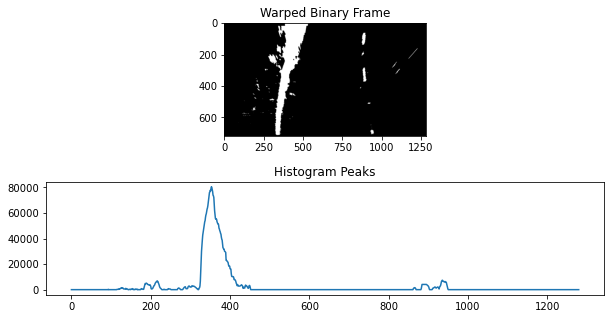

<string>:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
<string>:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#depre

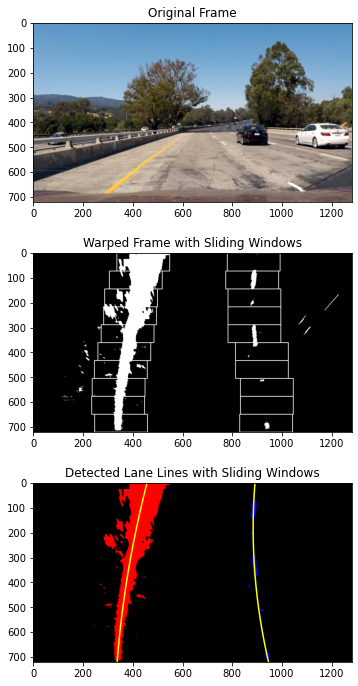

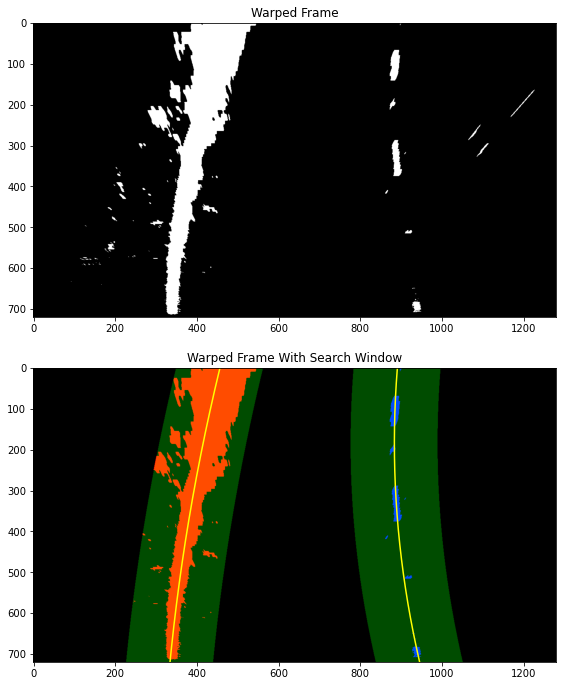

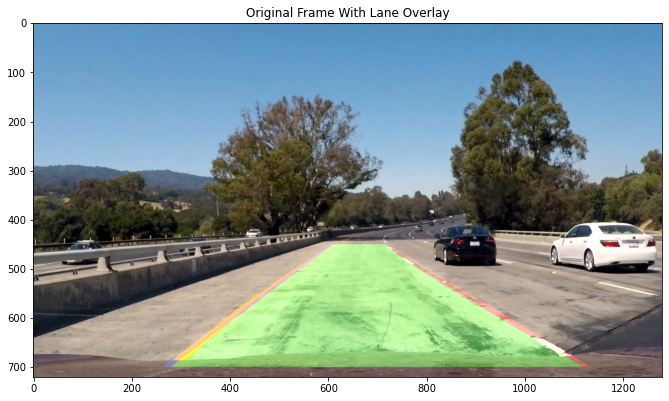

105.6716709695993 m 49.89234179994504 m
0.0004845737536931121m
=         TEST Images           =
straight_lines1.jpg	 straight_lines2.jpg	 test1.jpg	 test2.jpg	 

test3.jpg	 test4.jpg	 test5.jpg	 

test6.jpg	 
Select a file from the directory(q- quit): q


In [14]:
while 1:
    files = os.listdir('test_images')
    print("======================================")
    print("=         TEST Images           =")
    print("======================================")
    for i in files:
        print('{}\t '.format(i), end='')
        if files.index(i) % 3 == 0 and files.index(i) != 0:
            print('\n')
    print("\n======================================")

    # need to select image name with the extension (ex: img1.jpeg)1
    file = input("Select a file from the directory(q- quit): ").strip()
    # quit program
    if file == 'q' or file == 'Q':
        break
    image = 'test_images/' + file
    # Debug mode
    DEBUGGING_MODE = bool(input("DEBUGGING_MODE: -True -False ").strip())
    
    
    original_frame = cv2.imread(image)
    cv2.imshow('image', original_frame)
    cv2.waitKey(0)
    # Create a Lane object
    lane_obj = Lane(orig_frame=original_frame)
    # Perform thresholding to isolate lane lines
    lane_line_markings = lane_obj.get_line_markings()
 
    # Plot the region of interest on the image
    lane_obj.plot_roi(plot=DEBUGGING_MODE)
    # Perform the perspective transform to generate a bird's eye view
    # If Plot == True, show image with new region of interest
    warped_frame = lane_obj.perspective_transform(plot=DEBUGGING_MODE)
    print()
    print()
    # Generate the image histogram to serve as a starting point
    # for finding lane line pixels
    histogram = lane_obj.calculate_histogram(plot=DEBUGGING_MODE)
    # Find lane line pixels using the sliding window method 
    left_fit, right_fit = lane_obj.get_lane_line_indices_sliding_windows(plot=DEBUGGING_MODE)
    # Fill in the lane line
    lane_obj.get_lane_line_previous_window(left_fit, right_fit, plot=DEBUGGING_MODE)
    # Overlay lines on the original frame
    frame_with_lane_lines = lane_obj.overlay_lane_lines(plot=DEBUGGING_MODE)
    
    # Calculate lane line curvature (left and right lane lines)
    lane_obj.calculate_curvature(DEBUGGING_MODE)
    
    # Calculate center offset                                                                 
    lane_obj.calculate_car_position(DEBUGGING_MODE)
    # Display curvature and center offset on image
    frame_with_lane_lines2 = lane_obj.display_curvature_offset(frame=frame_with_lane_lines, plot=True)
     
    output_dir = 'output_images'
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    # save image containing highlighted defect
    cv2.imwrite('output_images/{}_thresholded.jpg'.format(file.split('.')[0]),frame_with_lane_lines2)     
    # Close all windows
    cv2.destroyAllWindows()